In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import joblib
from hepler import *
import warnings

sns.set_style("darkgrid")
sns.set_palette("Paired")
warnings.simplefilter(action="ignore", category=FutureWarning)

In [2]:
df = joblib.load("data/app_full_df")
app = joblib.load("data/app_df")
selected_feats_ls = joblib.load("data/models/selected_feats_ls")
df = df[["sk_id_curr"] + selected_feats_ls + ["target"]]

df = df.replace(999999, np.nan)
df = df.replace(-999999, np.nan)

In [3]:
# adjust some types for easy plotting
df["target"] = df.target.apply(
    lambda i: "no_payment_difficulty" if i == 0 else "payment_difficulty"
).astype("category")
df = df.dropna(subset=["is_female"])
df["is_female"] = df.is_female.apply(
    lambda i: "male" if i == False else "female"
).astype("category")
df = df.rename(columns={"is_female": "gender"})
df["flag_own_car"] = df.flag_own_car.apply(
    lambda i: "No" if i == False else "Yes"
).astype("category")

df["reg_city_not_live_city"] = df.reg_city_not_live_city.apply(
    lambda i: "Yes" if i == 1 else "No"
).astype("category")

df["flag_document_3"] = df.flag_document_3.apply(
    lambda i: "Yes" if i == 1 else "No"
).astype("category")

df["cash_loans_cnt_inst_decreases"] = df["cash_loans_cnt_inst_decreases"].astype("bool")

df["rej_history_reason_mode"] = df.rej_history_reason_mode.astype("object")
df = df.loc[df.rej_history_reason_mode != "XAP"]
df["rej_history_reason_mode"] = df.rej_history_reason_mode.astype("category")

df["cash_loans_cnt_inst_decreases"] = df.cash_loans_cnt_inst_decreases.fillna("unknown")
df["cash_loans_cnt_inst_decreases"] = df.cash_loans_cnt_inst_decreases.apply(
    lambda i: "Yes" if i == True else "No" if i == False else "unknown"
).astype("category")

df["region_rating_client"] = df.region_rating_client.apply(
    lambda i: "low" if i == 1 else "mid" if i == 2 else "high"
).astype("category")

##### Target data

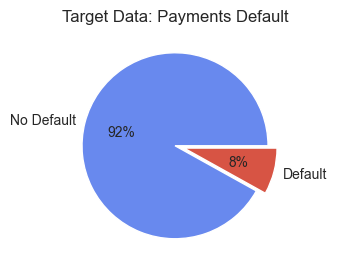

In [4]:
target_percentage = round(
    (100 * df.target.value_counts() / df.target.value_counts().sum()), 2
).tolist()
data = [target_percentage[0], target_percentage[1]]
keys = ["No Default", "Default"]

explode = [
    0,
    0.1,
]

fig_size(3, 4)
plt.pie(
    data, labels=keys, explode=explode, autopct="%.0f%%", colors=["#6889ee", "#d75444"]
)
plt.title("Target Data: Payments Default")
plt.show()

What is the source of selected features ?

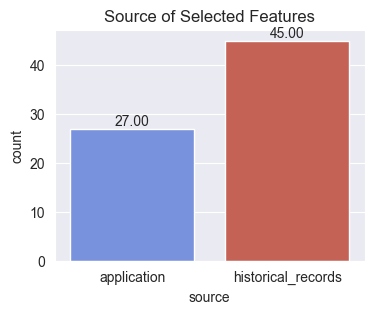

In [24]:
app_col = app.columns.tolist()
app_feats_count = len([i for i in df.columns.tolist() if i in app_col]) - 1
hist_feats_count = df.shape[1] - 2 - app_feats_count
fig_size(4, 3)
ax = sns.barplot(
    {"application": app_feats_count, "historical_records": hist_feats_count},
    palette=["#6889ee", "#d75444"],
)
mark_bar(ax)
plt.title("Source of Selected Features")
plt.xlabel("source")
plt.ylabel("count")

plt.show()

#### Distribution of categorical, ordinal and boolean features across target

In [28]:
low_cat_ls = []
mid_cat_ls = []
high_cat_ls = []
for i in df.select_dtypes("category").columns.tolist()[:-1]:
    nunq = df[i].nunique()
    if nunq > 10:
        high_cat_ls.append(i)
    if nunq < 10:
        low_cat_ls.append(i)
    if nunq > 3:
        mid_cat_ls.append(i)

##### Low Cardinality Categorical Features (< 8 categories):

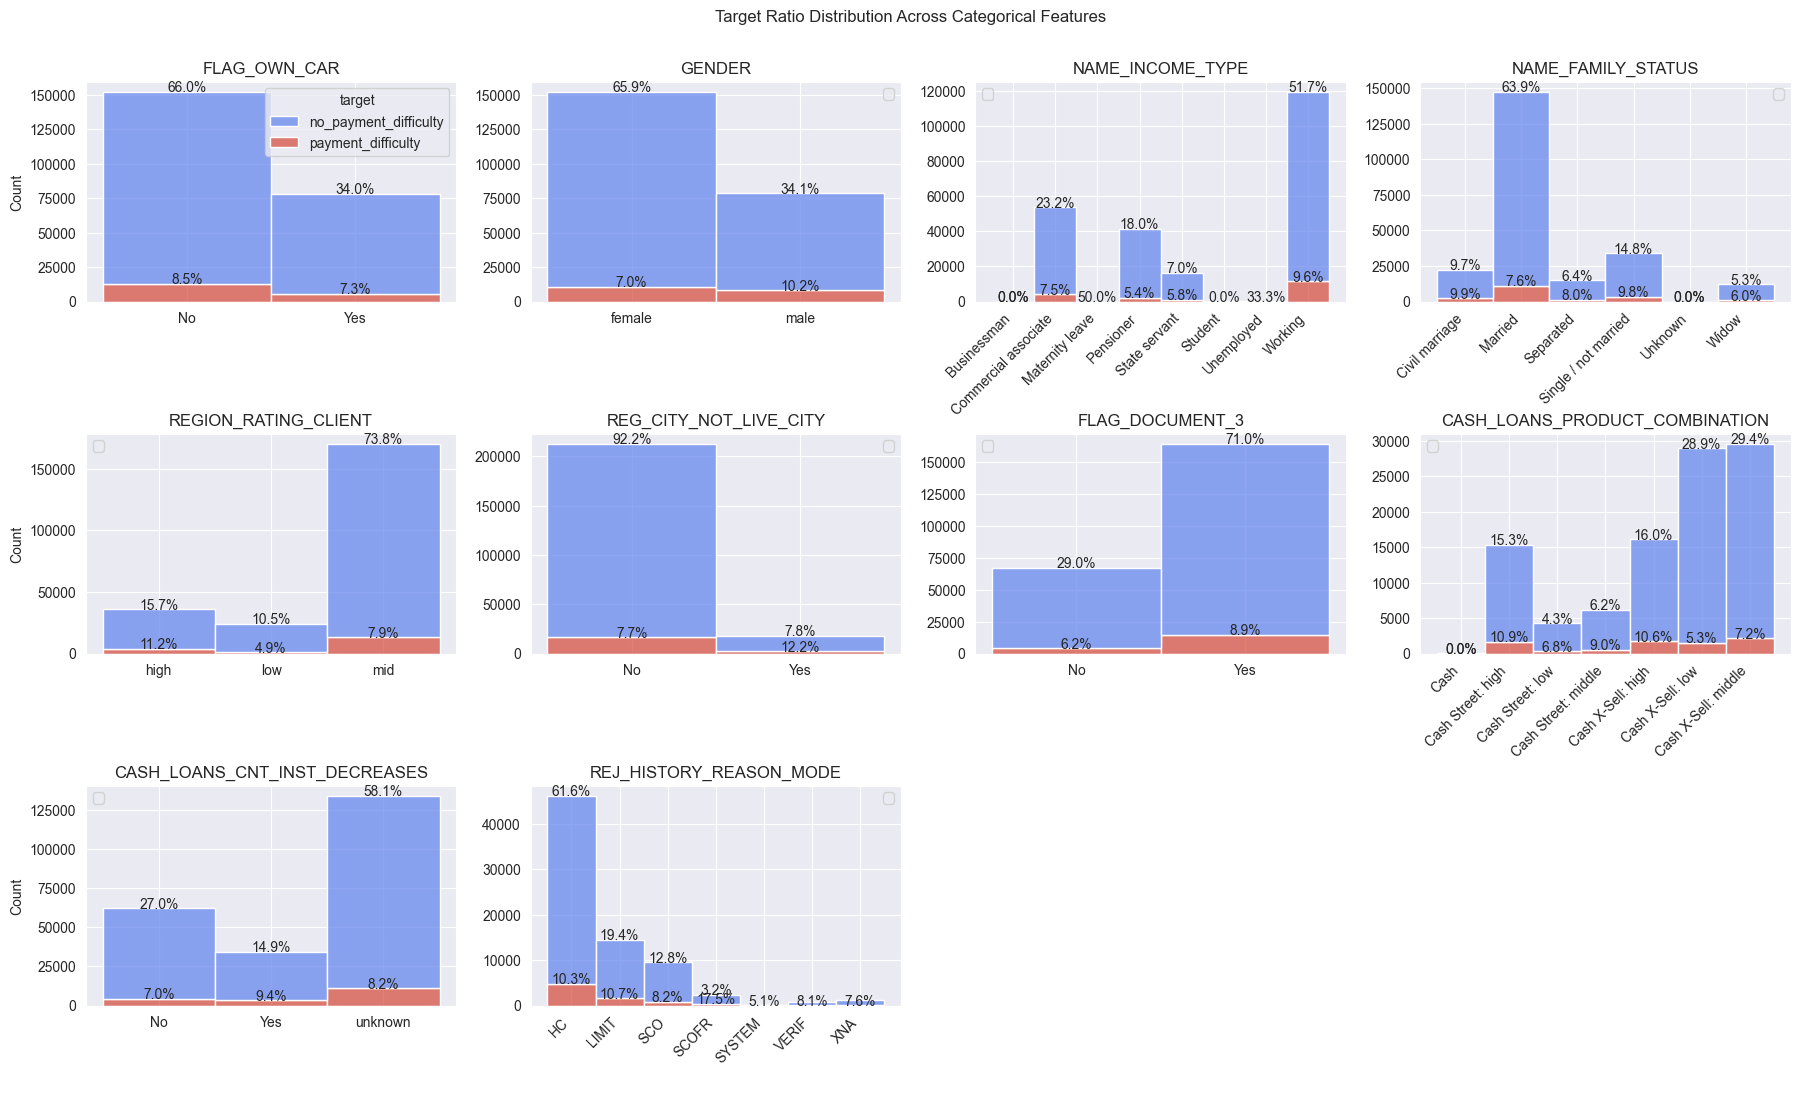

In [34]:
plt_ct = 1

fig_size(22, 12)
for i in df[low_cat_ls]:
    temp_df = df[[i, "target"]].dropna()
    plt.subplot(3, 4, plt_ct)
    plt.title(i.upper())
    plt.xlabel(" ")
    ax = sns.histplot(
        data=temp_df,
        x=i,
        hue="target",
        multiple="stack",
        palette=["#6889ee", "#d75444"],
    )
    if i == "name_income_type":
        mark_percent(
            ax,
            temp_df[i],
            temp_df.target,
            "payment_difficulty",
            hide_total=["Maternity leave", "Student", "Unemployed"],
        )
    elif i == "rej_history_reason_mode":
        mark_percent(
            ax,
            temp_df[i],
            temp_df.target,
            "payment_difficulty",
            hide_total=["SYSTEM", "VERIF", "XNA"],
        )
    else:

        mark_percent(ax, temp_df[i], temp_df.target, "payment_difficulty")
    if i in mid_cat_ls:
        plt.xticks(rotation=45, ha="right")

    if plt_ct != 1:
        plt.legend("")

    if plt_ct % 4 != 1:
        plt.ylabel(" ")

    plt_ct += 1

plt.subplots_adjust(wspace=0.2, hspace=0.6)
plt.suptitle("Target Ratio Distribution Across Categorical Features", y=0.94)
plt.show()

📝 Categories with big payment_difficulty_ratio difference:

`name_income_type`: 
- maternative_leave = 50% , unemployed = 30% 
- business_man, student = 0% 

- `rejection_history_reason`: SCOFR = 17.5% (fico score look-up)

In [36]:
plt_df_ls = []
for i in df[high_cat_ls]:
    plt_df = pd.DataFrame()
    ct = pd.crosstab(df[i], df.target)
    plt_df["category_percentage"] = ct.no_payment_difficulty + ct.payment_difficulty
    occ_sum = plt_df["category_percentage"].sum()
    plt_df["category_percentage"] = plt_df["category_percentage"] * 100 / occ_sum

    plt_df["default_percentage"] = (
        ct.payment_difficulty * 100 / (ct.no_payment_difficulty + ct.payment_difficulty)
    )
    plt_df_ls.append(plt_df)

##### High Cardinality Categorical Features (> 10 categories):

📊 Organization Type


Organization Type

mean category_percentage
1.72 %

mean default_percentage
7.94 %


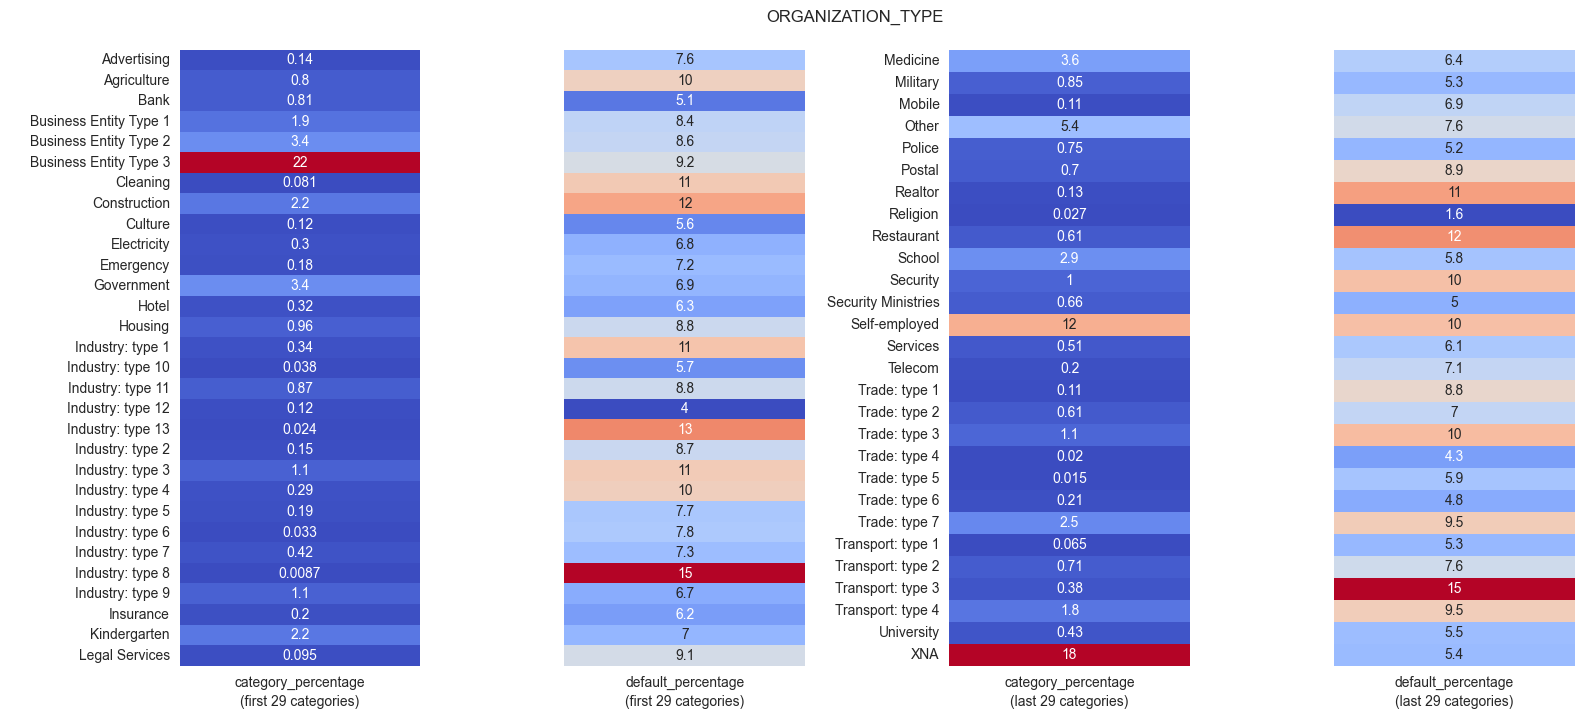

In [37]:
bprint("Organization Type")
bprint("mean category_percentage")
print(round(plt_df_ls[1].category_percentage.mean(), 2), "%")
bprint("mean default_percentage")
print(round(plt_df_ls[1].default_percentage.mean(), 2), "%")

fig_size(18, 8)
plt.subplot(1, 4, 1)
sns.heatmap(
    pd.DataFrame(plt_df_ls[1].category_percentage[:30]),
    annot=True,
    cmap="coolwarm",
    cbar=False,
)
plt.ylabel(" ")
plt.xlabel("(first 29 categories)")

plt.subplot(1, 4, 2)
sns.heatmap(
    pd.DataFrame(plt_df_ls[1].default_percentage[:30]),
    annot=True,
    cmap="coolwarm",
    cbar=False,
)

plt.yticks([])
plt.ylabel(" ")
plt.xlabel("(first 29 categories)")

plt.subplot(1, 4, 3)
sns.heatmap(
    pd.DataFrame(plt_df_ls[1].category_percentage[30:]),
    annot=True,
    cmap="coolwarm",
    cbar=False,
)
plt.ylabel(" ")
plt.xlabel("(last 29 categories)")

plt.subplot(1, 4, 4)
sns.heatmap(
    pd.DataFrame(plt_df_ls[1].default_percentage[30:]),
    annot=True,
    cmap="coolwarm",
    cbar=False,
)

plt.yticks([])
plt.ylabel(" ")
plt.xlabel("(last 29 categories)")

plt.subplots_adjust(hspace=0.3, wspace=0.6)
plt.suptitle("organization_type".upper(), y=0.93)

plt.show()

📝 Organization type has in total 58 different categories.

The most common categories are Business type 3 and self-employed, combined account \
for around 1/3 of the dataset.

Categories with higher payment difficulties are mostly labour related \
professions such as agriculture, cleaning, construction, transport ... \

📊 Occupation Type


Occupation Type

mean category_percentage
5.26 %

mean payment_difficulty_percentage
8.55 %


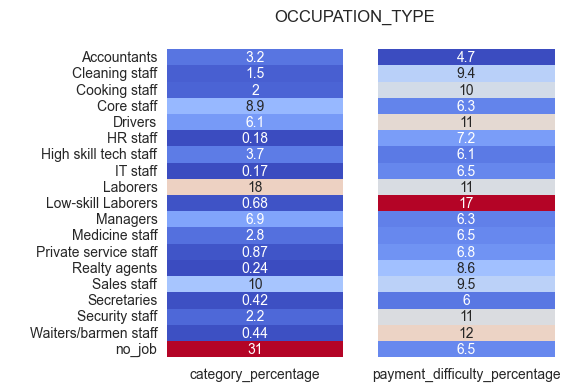

In [93]:
bprint("Occupation Type")
bprint("mean category_percentage")
print(round(plt_df_ls[0].category_percentage.mean(), 2), "%")
bprint("mean payment_difficulty_percentage")
print(round(plt_df_ls[0].payment_difficulty_percentage.mean(), 2), "%")


fig_size(5, 4)
plt.subplot(1, 2, 1)
sns.heatmap(
    pd.DataFrame(plt_df_ls[0]["category_percentage"]),
    annot=True,
    cmap="coolwarm",
    cbar=False,
)
plt.ylabel(" ")


plt.subplot(1, 2, 2)
sns.heatmap(
    pd.DataFrame(plt_df_ls[0].payment_difficulty_percentage),
    annot=True,
    cmap="coolwarm",
    cbar=False,
)

plt.yticks([])
plt.ylabel(" ")
plt.subplots_adjust(hspace=0.3)
plt.suptitle("occupation_type".upper())

plt.show()

📝 People working for office jobs have lower chance to have payment difficulties \
and vice versa, this aligns with our findings in the organization_type above.

- `occupation_type`: low_skill_laborers = 17%, \
cooking_staff, drivers, laborers, security_staff, bar_staff > 10%


📊 Comsumer Loan Goods


Consumer Loan Goods

mean category_percentage
3.85 %

mean payment_difficulty_percentage
7.39 %


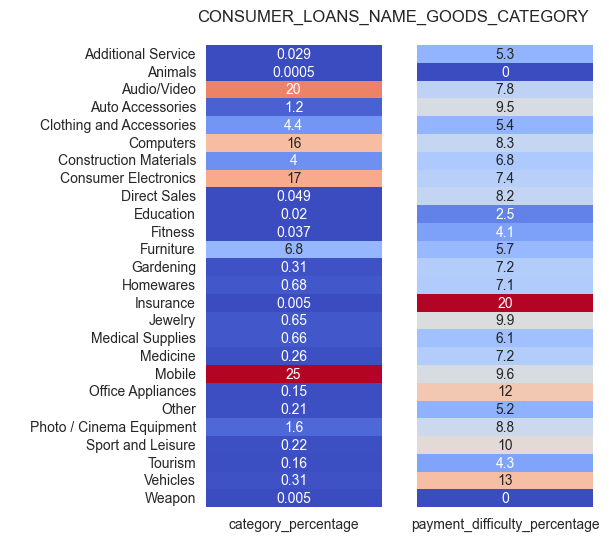

In [94]:
bprint("Consumer Loan Goods")
bprint("mean category_percentage")
print(round(plt_df_ls[2].category_percentage.mean(), 2), "%")
bprint("mean payment_difficulty_percentage")
print(round(plt_df_ls[2].payment_difficulty_percentage.mean(), 2), "%")


fig_size(5, 6)
plt.subplot(1, 2, 1)
sns.heatmap(
    pd.DataFrame(plt_df_ls[2]["category_percentage"]),
    annot=True,
    cmap="coolwarm",
    cbar=False,
)
plt.ylabel(" ")


plt.subplot(1, 2, 2)
sns.heatmap(
    pd.DataFrame(plt_df_ls[2].payment_difficulty_percentage),
    annot=True,
    cmap="coolwarm",
    cbar=False,
)

plt.yticks([])
plt.ylabel(" ")
plt.subplots_adjust(hspace=0.3, wspace=0.2)
plt.suptitle("consumer_loans_name_goods_category".upper(), y=0.94)

plt.show()

More than 50% of the consumer loan is for electronics (mobile, computers...).

- `consumer_loan_goods_name`: insurance = 20%, \
auto_accesorries/ vehicles/ office_appliances/ jewelry/ mobile/ sports_leisure >~ 10% \
weapon/ education/ animals 0 ~ 2.5 %

#### Distribution of numerical features and target

##### Numerical Features in Application Data

In [40]:
consumer_loan_feats = [
    i
    for i in df.select_dtypes(["int", "float"]).columns.tolist()
    if i.startswith("consumer_loans")
]

cash_loan_feats = [
    i
    for i in df.select_dtypes(["int", "float"]).columns.tolist()
    if i.startswith("cash_loans")
]

revolving_loan_feats = [
    i
    for i in df.select_dtypes(["int", "float"]).columns.tolist()
    if i.startswith("revolving_loans")
]

past_loan_feats = consumer_loan_feats + cash_loan_feats + revolving_loan_feats

past_loan_feats_dict = {
    "consumer": consumer_loan_feats,
    "cash": cash_loan_feats,
    "revolving": revolving_loan_feats,
}

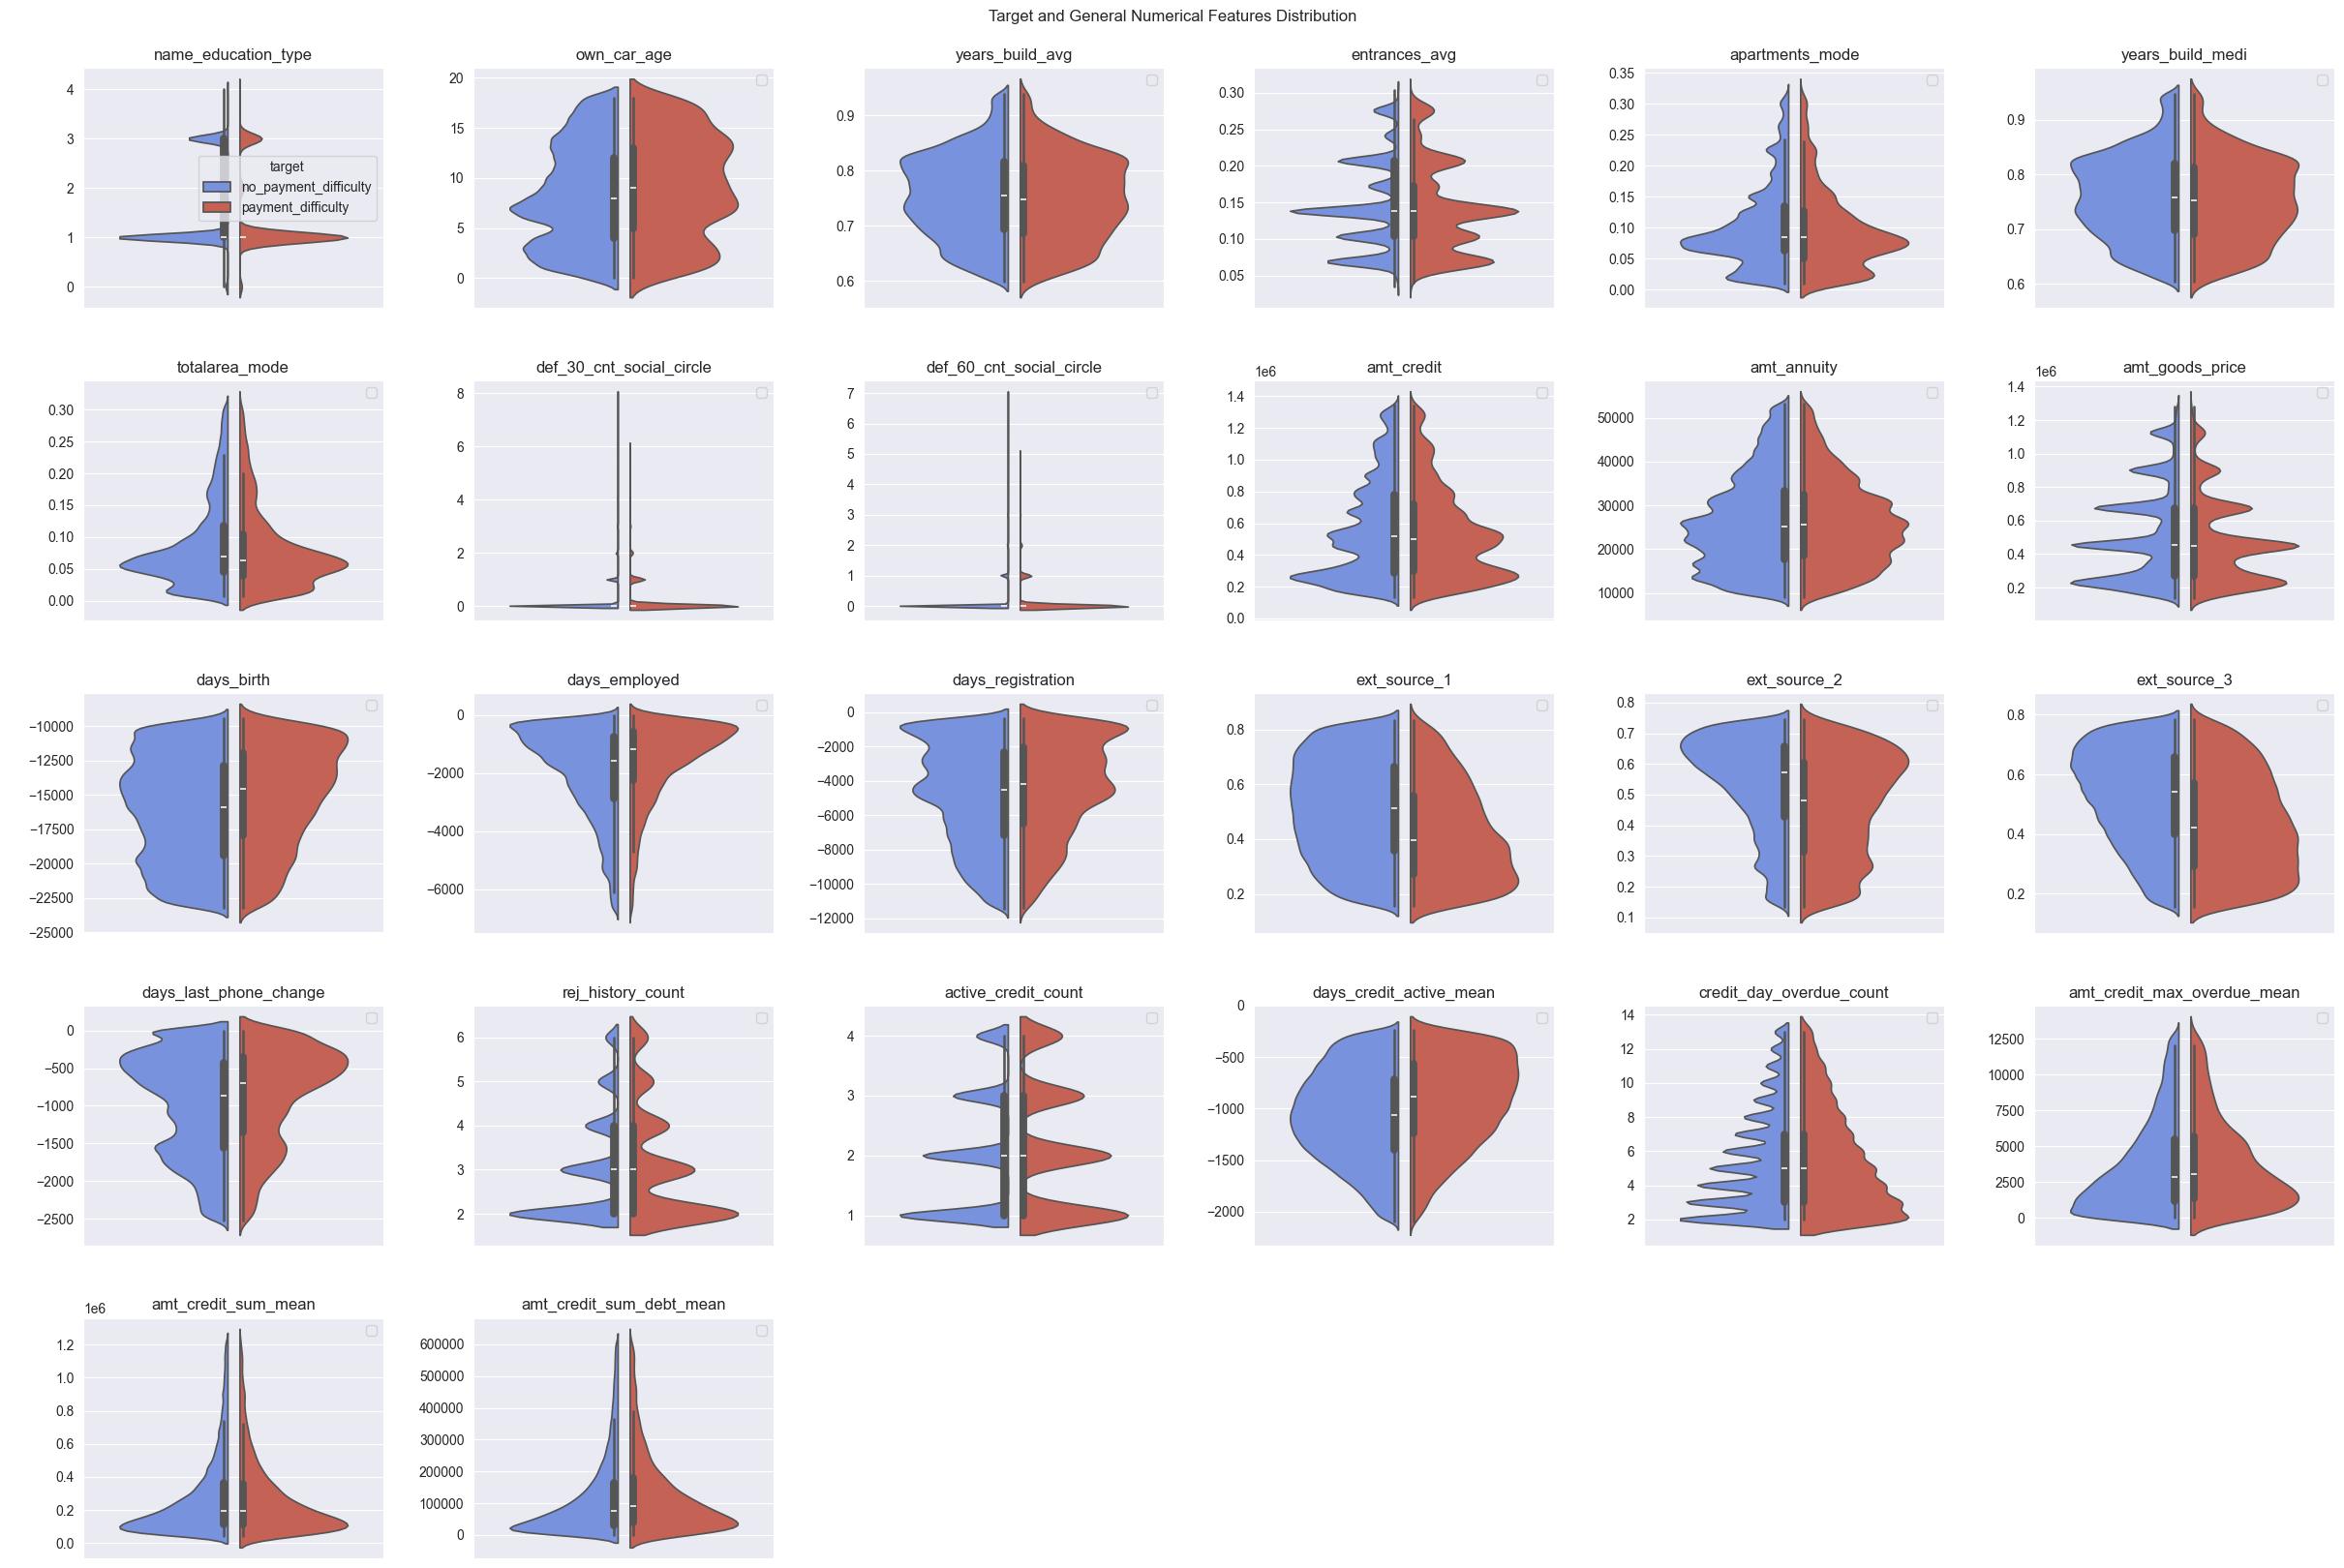

In [43]:
num_cols = df.select_dtypes(["int", "float"]).columns.tolist()[1:]
num_cols = [i for i in num_cols if i not in past_loan_feats]

plt_ct = 1
fig_size(30, 20)
for i in num_cols:
    tg_df = df[[i, "target"]].dropna()
    if i == "name_education_type":
        max_val = 5
        min_val = -1
    elif i in [
        "def_30_cnt_social_circle",
        "def_60_cnt_social_circle",
    ]:
        max_val = tg_df[i].max()
        min_val = -1
    else:
        max_val = np.percentile(tg_df[i], 95)
        min_val = np.percentile(tg_df[i], 5)

    tg_df = tg_df.loc[(tg_df[i] < max_val) & (tg_df[i] > min_val)]

    plt.subplot(5, 6, plt_ct)
    sns.violinplot(
        data=tg_df,
        y=i,
        split=True,
        gap=0.1,
        hue="target",
        palette=["#6889ee", "#d75444"],
    )
    plt.ylabel(" ")
    plt.title(i)
    if plt_ct != 1:
        plt.legend("")

    plt_ct += 1

plt.subplots_adjust(wspace=0.3, hspace=0.3)
plt.suptitle("Target and General Numerical Features Distribution", y=0.91)
plt.show()

Crude impression of people who have higher chance of payment difficulty:

Basic info:
- Less higher education
- Older car
- Younger building
- Smaller total building area
- Lower amt_credit
- Higher amt_annuity
- Younger
- Shorter employment history
- Shorter credit registration record
- Worse score on 3 external credit sources
- Change phone number more recently

##### Numerical Features in Loan Type Specific Historical Data

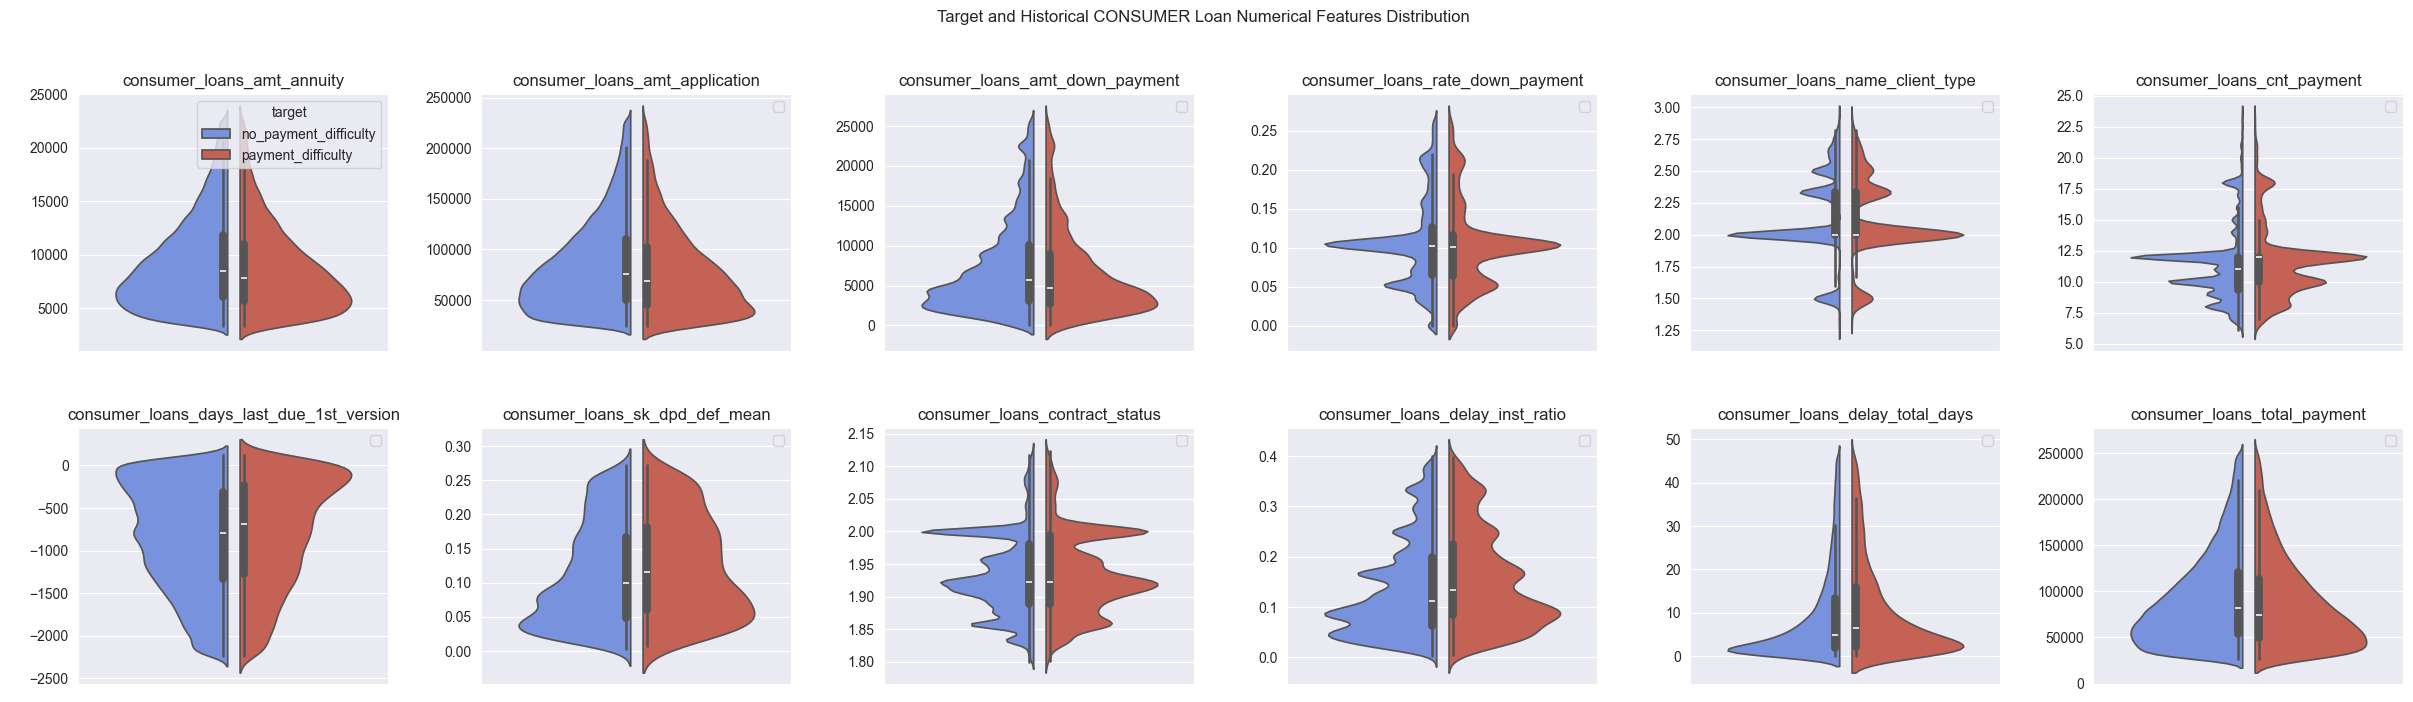

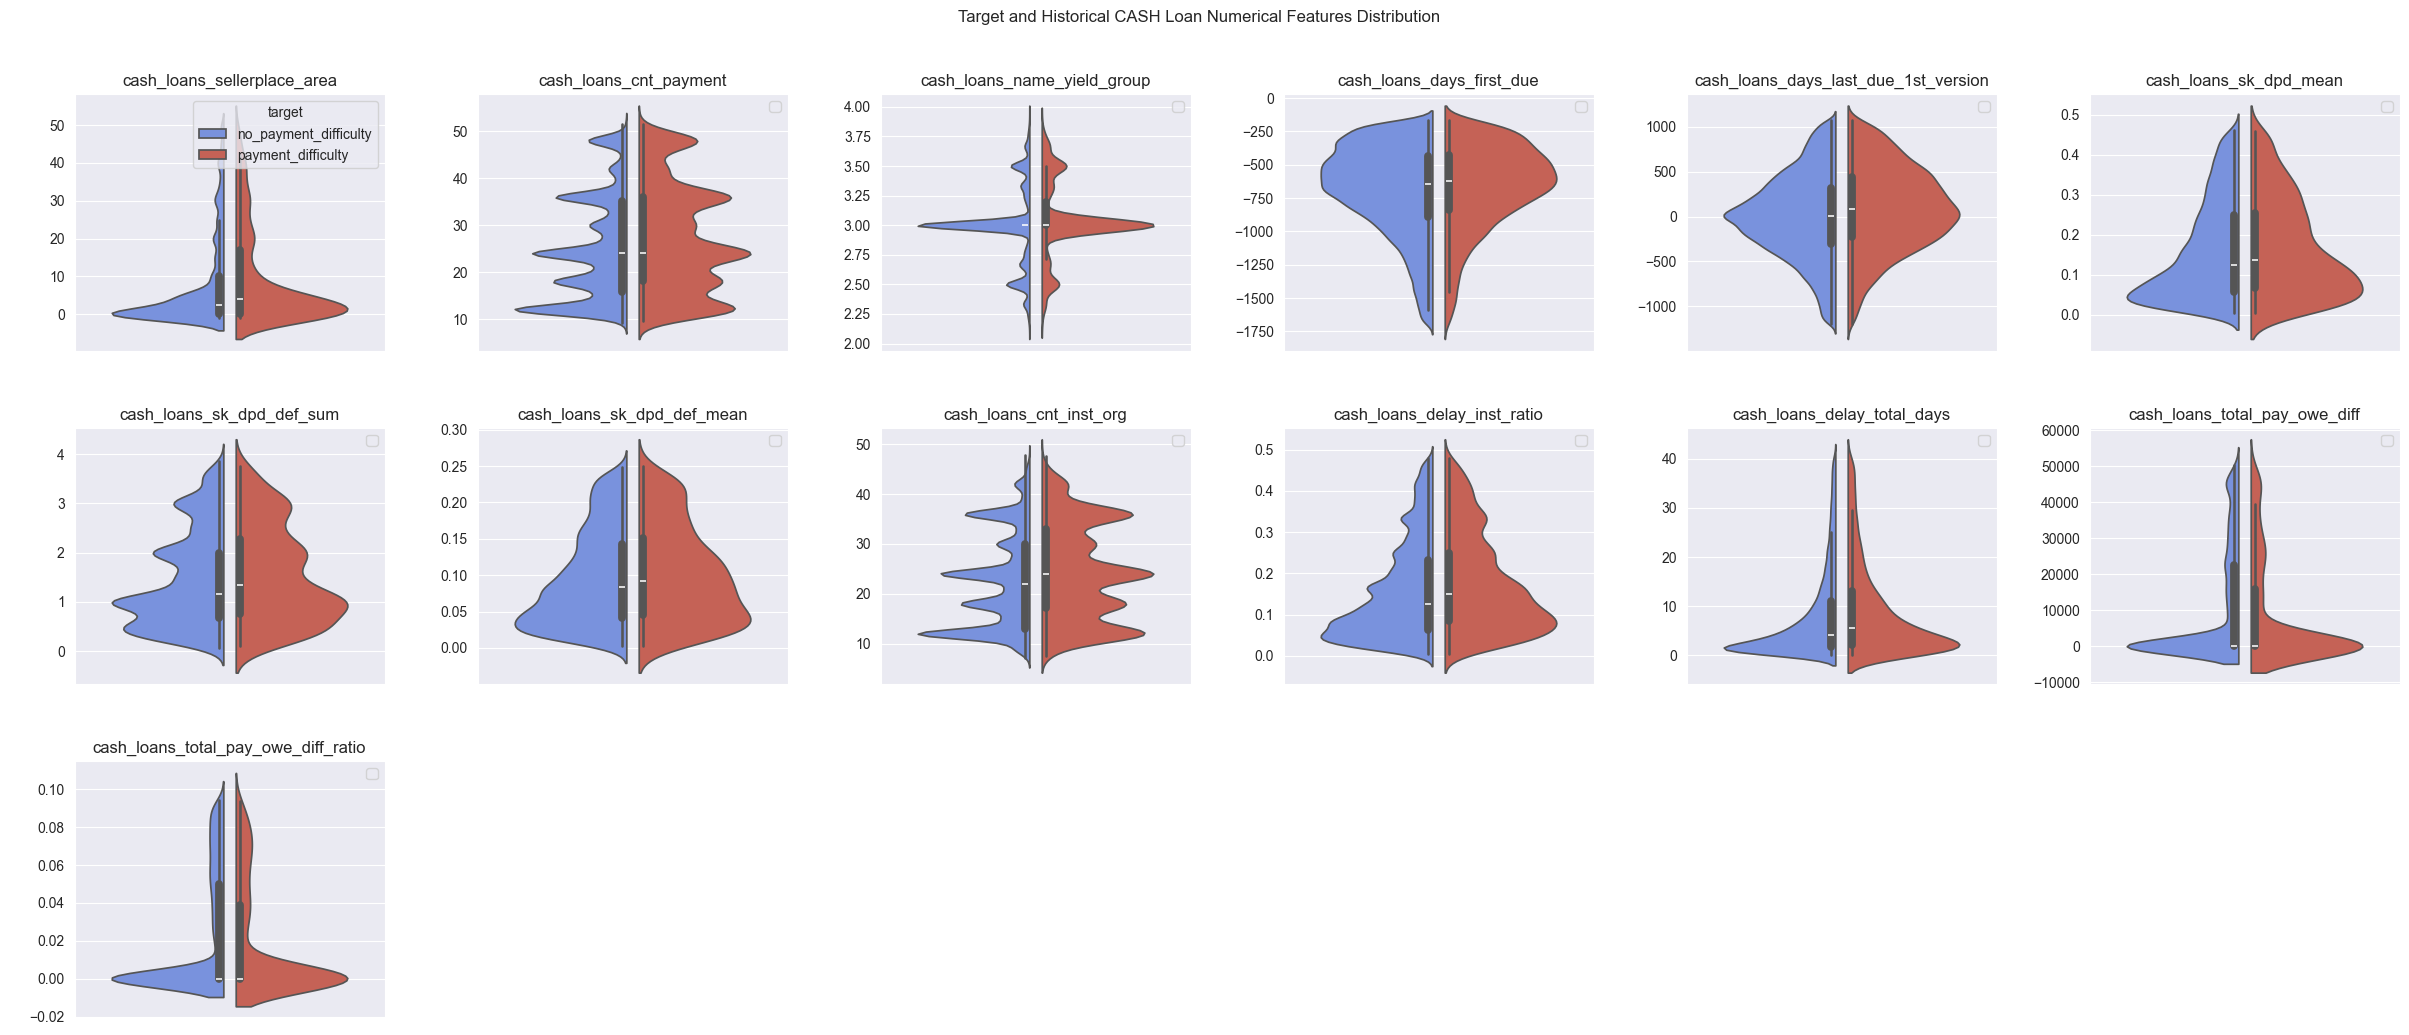

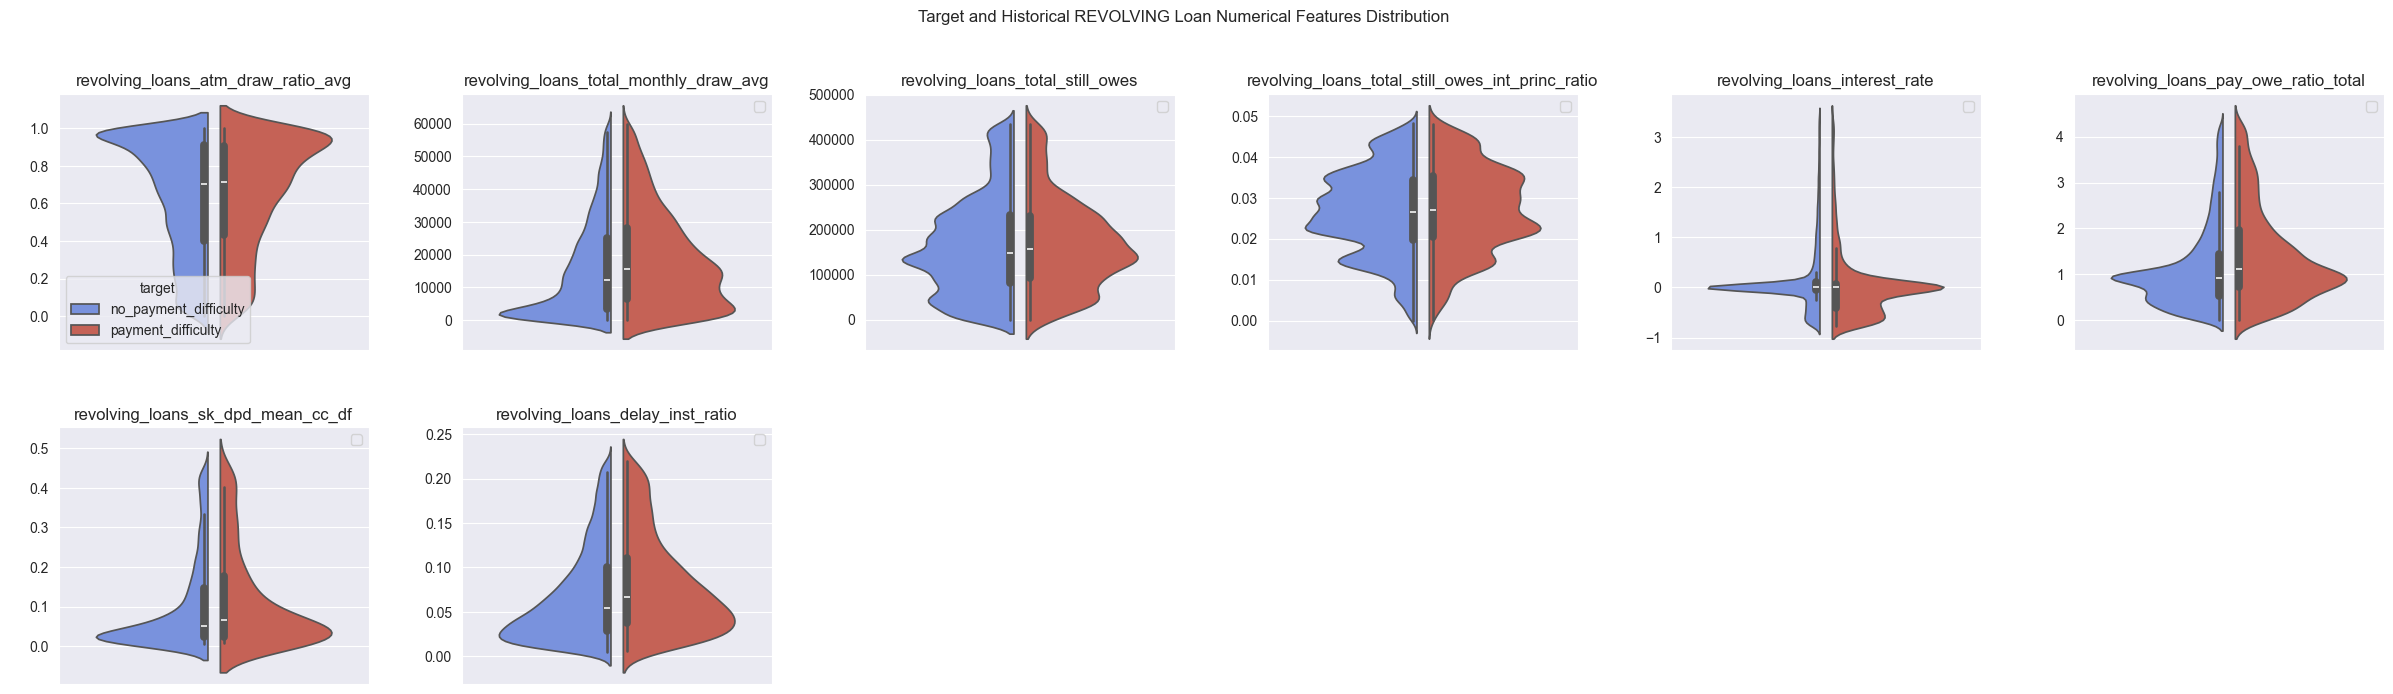

In [44]:
for loan_typ in ["consumer", "cash", "revolving"]:
    num_cols = past_loan_feats_dict[loan_typ]

    plt_ct = 1
    fig_size(30, 12)
    for i in num_cols:
        tg_df = df[[i, "target"]].dropna()

        if i in [
            "cash_loans_total_pay_owe_diff",
            "cash_loans_total_pay_owe_diff_ratio",
        ]:
            max_val = np.percentile(tg_df[i], 85)
            min_val = np.percentile(tg_df[i], 15)
        else:
            max_val = np.percentile(tg_df[i], 95)
            min_val = np.percentile(tg_df[i], 5)

        tg_df = tg_df.loc[(tg_df[i] < max_val) & (tg_df[i] > min_val)]

        plt.subplot(3, 6, plt_ct)
        sns.violinplot(
            data=tg_df,
            y=i,
            split=True,
            gap=0.1,
            hue="target",
            palette=["#6889ee", "#d75444"],
        )
        plt.ylabel(" ")
        plt.title(i)
        if plt_ct != 1:
            plt.legend("")

        plt_ct += 1

    plt.subplots_adjust(wspace=0.3, hspace=0.3)
    plt.suptitle(
        f"Target and Historical {loan_typ.upper()} Loan Numerical Features Distribution",
        y=0.95,
    )
    plt.show()

People who have payment difficlty based on past loan record:

1. Consumer Loan
- Lower amt_annuity, application, and down payment 
- Higher payment counts
- Higher sk_dpd delay
- Higher delayed instalment
- Lower total payment

2. Cash Loan
- Higher days first due and days last due
- Higher sk_dpd delay
- More delay total days
- More instalments

3. Revolving Loan (credit card)
- Higher monthly draw average
- Higher total_still_owes
- Lower interest rate
- Higher pay_owe_ratio
- Higher delay days

These 3 loans are very different by nature, but we can get a crude picture of \
records that have higher payment difficulty:

1. Delay history
2. Lower payment
3. Higher instalment counts